In [178]:
import numpy as np
from numpy import cos, sin, pi

import matplotlib.pyplot as plt

import sympy as sp

In [179]:
def robot_lines(links, joints, base):
    
    # Convert to list if it's an ndarray
    if (isinstance(joints, np.ndarray)):
        joints = joints.flatten().tolist()
    
    xb, yb = base
    
    xs = [xb]
    ys = [yb]
    
    total_len = sum(links)
    
    total_q = 0
    
    for l,q in zip(links, joints):
        
        total_q += q
        
        xs.append(xs[-1] + l * cos(total_q))
        ys.append(ys[-1] + l * sin(total_q))
        
    #plt.figure(figsize=(8,8))
    #plt.plot(xs, ys)
    #plt.ylim(-1 * total_len, total_len)
    #plt.xlim(-1 * total_len, total_len)
    #plt.title('Robot Manipulator Pose')
    
    return xs, ys

In [212]:
def plot_robots(xs_list, ys_list, target):
    
    plt.figure(figsize=(8,8))
    plt.axis('equal')
    
    for xs, ys in zip(xs_list, ys_list):
        plt.plot(xs, ys)
        
    plt.plot(target[0], target[1], 'o')
        
    plt.title('Robot Manipulator Pose')
    
    plt.grid()
    
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    
    return

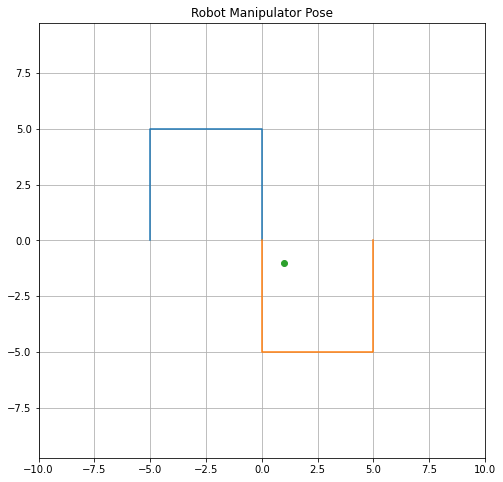

In [217]:
xs1, ys1 = robot_lines([5, 5, 5], [pi/2, -pi/2, -pi/2], (-5, 0))
xs2, ys2 = robot_lines([5, 5, 5], [-pi/2, -pi/2, -pi/2], (5, 0))

xs = [xs1,xs2]
ys = [ys1,ys2]

xs, ys

tar = np.array([[1],[1]])

theta_total = sum([pi/2, -pi/2, -pi/2])
        
R = np.array([[cos(theta_total), -1*sin(theta_total)],
              [sin(theta_total), cos(theta_total)]])

tar_rel = (R @ tar) + f_kine([5, 5, 5], [pi/2, -pi/2, -pi/2], (-5, 0))

plot_robots(xs, ys, tar_rel)

In [182]:
def f_kine(links, joints, base):
    
    # Convert to list if it's an ndarray
    if (isinstance(joints, np.ndarray)):
        joints = joints.flatten().tolist()
    
    x,y = base
    
    total_len = sum(links)
    
    total_q = 0
    
    for l,q in zip(links, joints):
        
        total_q += q
        
        x += l * cos(total_q)
        y += l * sin(total_q)
        
    return np.array([[x],[y]])

In [184]:
def jacobian(links, joints):
    
    # Convert to list if it's an ndarray
    if (isinstance(joints, np.ndarray)):
        joints = joints.flatten().tolist()
            
    # Form symbolic q matrix
    
    qs = []
    
    for i in range(0,len(joints)):
        
        qs.append(sp.Symbol('q{}'.format(i)))
        
        
    jac = np.zeros((2, len(links)))
    
    x = 0
    y = 0
    
    # Form forward kinematics
    for i in range(len(links)):
                   
        total_q = 0
        
        for j in range(i + 1):
            
            total_q += qs[j]
            
        x += links[i] * sp.cos(total_q)
        y += links[i] * sp.sin(total_q)
        
    
    # Differentiate to find jacobian      
    for i in range(len(links)):
        
        Jx = sp.diff(x, qs[i])
        Jy = sp.diff(y, qs[i])
        
        for k in range(len(links)):
            
            Jx = Jx.subs(qs[k], joints[k])
            Jy = Jy.subs(qs[k], joints[k])
                
        jac[0,i] = Jx.evalf()
        jac[1,i] = Jy.evalf()
            
    return jac

In [253]:
# Note: this ONLY works for targets within the workspace. For points outside the workspace this function will not exit

# We use four frames here:
#  Frame 1: Base of Robot 1
#  Frame 2: EF of Robot 1
#  Frame 3: EF of Robot 2
#  Frame 4: Base of Robot 2

# We are ignoring the wrench matrix for this operation

def i_kine_dual(links_1, joints_1, base_1, links_2, joints_2, base_2, target, error_trace=False):
    
    current_q_1 = joints_1
    current_q_2 = joints_2
    
    # This term limits the maximum delta x per move
    max_move = 2
    
    e_trace = []
    
    while(1):
        
        # Get the current rotation between frames 1 and 2
                
        theta_total = np.sum(current_q_1)
        
        R = np.array([[cos(theta_total), -1*sin(theta_total)],
                      [sin(theta_total), cos(theta_total)]])
                
        # Get the current target effector position in frame 1
        current_x_1 = f_kine(links_1, current_q_1, base_1)
        current_x_2 = f_kine(links_2, current_q_2, base_2)
                
        current_x_2_rel = R.T @ (current_x_2 - current_x_1)
        
        # Get the vector to the target
        delta_x = target - current_x_2_rel
                
        # Find the magnitude of the movement required
        delta_x_norm = np.linalg.norm(delta_x)
        
        #print(delta_x_norm)
        
        e_trace.append(delta_x_norm)
        
        # Limit the maximum magnitude of delta_x
        if (delta_x_norm > max_move):
            
            delta_x /= (delta_x_norm / max_move)
            
        # Stop if the end effector is sufficently close to target
        if (delta_x_norm < 0.001):
            
            break
            
        jac1 = jacobian(links_1, current_q_1)
        jac2 = jacobian(links_2, current_q_2)
                
        jac_rel = np.hstack((-1*R.T@jac1, R.T@jac2))
        
        # Jacobian pseudoinversion
        jac_rel_pinv = np.linalg.pinv(jac_rel)
        
        # Find the required movements in the joint space
        Alpha = 0.4
        Lambda = 5
        
        #delta_q = alpha * jac_rel_pinv @ delta_x
        
        delta_q = Alpha * np.linalg.inv(jac_rel.T@jac_rel + Lambda**2*np.eye(jac_rel.shape[1])) @ jac_rel.T @ delta_x
        
        # Add the change to find the updated joint angles
        current_q_1 += delta_q[:len(current_q_1),:]
        current_q_2 += delta_q[len(current_q_1):,:]
        
        #print(" ")
        
    return (current_q_1, current_q_2, e_trace) if error_trace else (current_q_1, current_q_2)

Text(0.5, 1.0, 'Error Trace')

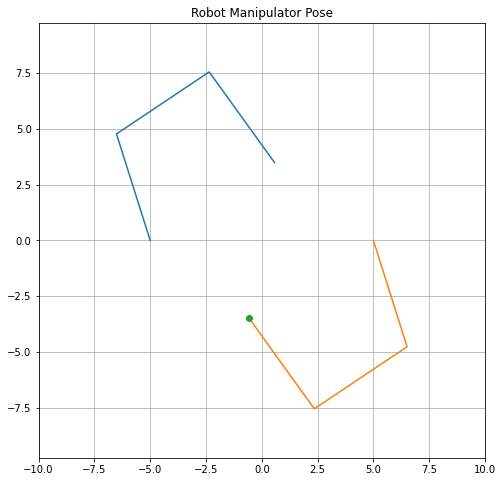

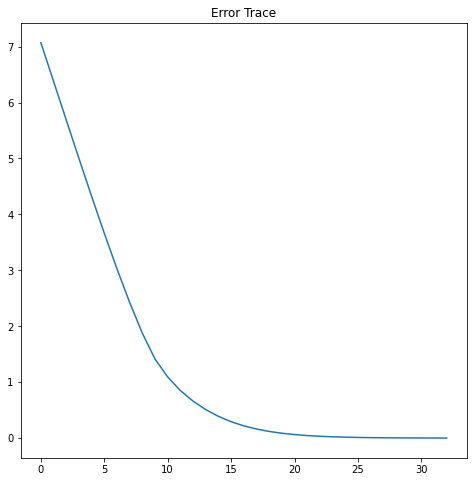

In [254]:
# Robot 1
links_1 = [5, 5, 5]
joints_1 = np.array([[pi/2], [-pi/2], [-pi/2]])
base_1 = (-5, 0)

# Robot 2
links_2 = [5, 5, 5]
joints_2 = np.array([[-pi/2], [-pi/2], [-pi/2]])
base_2 = (5, 0)

target = np.array([[5.0],[-5.0]])

qs1, qs2, e_trace = i_kine_dual(links_1, joints_1, base_1, links_2, joints_2, base_2, target, error_trace=True)

xs1, ys1 = robot_lines(links_1, qs1, base_1)
xs2, ys2 = robot_lines(links_2, qs2, base_2)

theta_total = sum(qs1)
        
R = np.array([[cos(theta_total), -1*sin(theta_total)],
              [sin(theta_total), cos(theta_total)]])

R = R.squeeze()

tar_rel = (R @ target) + f_kine(links_1, qs1, base_1)

xs = [xs1,xs2]
ys = [ys1,ys2]

xs, ys

plot_robots(xs, ys, tar_rel)

plt.figure(figsize=(8,8))
plt.plot(e_trace)
plt.title('Error Trace')